In [ ]:
# Create train, validation and test splits

from sklearn.model_selection import train_test_split
import pandas as pd

# Specify the columns you want to read
columns_to_read = ['heatmapsId', 'playerId', 'teamId', 'season', 'passes-start-heatmap']

# Read the CSV file with only the specified columns
data = pd.read_csv('_normalized-heatmaps/normalized-heatmaps-chunk-1.csv', usecols=columns_to_read)

# Split into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% train
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)  # 20% val, 10% test

# Save to CSV
train_data.to_csv("_Data-split/passes-start-train.csv", index=False)
val_data.to_csv("_Data-split/passes-start-validation.csv", index=False)
test_data.to_csv("_Data-split/passes-start-test.csv", index=False)

In [ ]:
# Test with normalization [0,1]

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

# Specify the columns you want to read
columns_to_read = ['heatmapsId', 'playerId', 'teamId', 'season', 'passes-start-heatmap']

# Read the CSV file with only the specified columns
data = pd.read_csv('_normalized-heatmaps/normalized-heatmaps-chunk-1.csv', usecols=columns_to_read)

# Normalize the heatmap values
def normalize_heatmap(heatmap_str, range_min=-1, range_max=1):
    # Convert the heatmap string to a numpy array
    heatmap = np.array(eval(heatmap_str))  # Assuming the heatmap is stored as a string of lists

    # Normalize to the desired range
    heatmap_min, heatmap_max = heatmap.min(), heatmap.max()
    #print(f"Min: {heatmap_min}\nMax: {heatmap_max}")
    normalized_heatmap = ((heatmap - heatmap_min) / (heatmap_max - heatmap_min))  # [0, 1] scaling
    
    return normalized_heatmap.tolist()  # Convert back to list

# Apply normalization and save as JSON strings
data['passes-start-heatmap'] = data['passes-start-heatmap'].apply(
    lambda x: json.dumps(normalize_heatmap(x))
)

# Split into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% train
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)  # 20% val, 10% test

# Save to CSV
train_data.to_csv("_Data-split/passes-start-train.csv", index=False)
val_data.to_csv("_Data-split/passes-start-validation.csv", index=False)
test_data.to_csv("_Data-split/passes-start-test.csv", index=False)

In [ ]:
# normalizing data through a sigmoid function
# seems to work quite well as an embedder

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

# Specify the columns you want to read
columns_to_read = ['heatmapsId', 'playerId', 'teamId', 'season', 'passes-start-heatmap']

# Initialize an empty list to store data from each file
all_data = []

# Loop through files and read data
for k in range(1, 6):  # Loop through files 1 to 5
    file_path = f'_normalized-heatmaps/normalized-heatmaps-chunk-{k}.csv'
    data_chunk = pd.read_csv(file_path, usecols=columns_to_read)
    all_data.append(data_chunk)

# Concatenate all the data into a single DataFrame
data = pd.concat(all_data, ignore_index=True)

# Apply sigmoid to the heatmap values
def sigmoid_heatmap(heatmap_str):
    # Convert the heatmap string to a numpy array
    heatmap = np.array(eval(heatmap_str))  # Assuming the heatmap is stored as a string of lists

    # Apply sigmoid
    sigmoid_heatmap = 1 / (1 + np.exp(-heatmap))  # Sigmoid function
    
    return sigmoid_heatmap.tolist()  # Convert back to list

# Apply sigmoid transformation and save as JSON strings
data['passes-start-heatmap'] = data['passes-start-heatmap'].apply(
    lambda x: json.dumps(sigmoid_heatmap(x))
)

# Split into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% train
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)  # 20% val, 10% test

# Save to CSV
train_data.to_csv("_Data-split/passes-start-train.csv", index=False)
val_data.to_csv("_Data-split/passes-start-validation.csv", index=False)
test_data.to_csv("_Data-split/passes-start-test.csv", index=False)

In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.4.1+cu121
CUDA available: True


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import json
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt

class HeatmapCSVLoader(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.heatmaps = self.data["passes-start-heatmap"]
        self.ids = self.data["heatmapsId"]
        self.playerIds = self.data["playerId"]
        self.teamIds = self.data["teamId"]
        self.seasons = self.data["season"]
    
    def __len__(self):
        return len(self.heatmaps)
    
    def __getitem__(self, idx):
        # Parse heatmap JSON string
        heatmap = json.loads(self.heatmaps.iloc[idx])
        heatmap_tensor = torch.tensor(heatmap, dtype=torch.float32)  # Convert to tensor
        
        # Add channel dimension for PyTorch (batch, channel, height, width)
        heatmap_tensor = heatmap_tensor.unsqueeze(0)
        
        # Return heatmap tensor and its metadata
        return heatmap_tensor, self.ids.iloc[idx], self.playerIds.iloc[idx], self.teamIds.iloc[idx], self.seasons.iloc[idx]    

In [3]:
# Load datasets
train_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmod-1chunk/1passes-start-train.csv")
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmod-1chunk/1passes-start-validation.csv")
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [ ]:
#import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size):
        super(Encoder, self).__init__()
        
        # Conv Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.3)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Conv Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, groups=64),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.3)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Conv Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(p=0.3)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Compute flattened size after convolutions and pooling
        self.flattened_size = 256 * 4 * 2  # Computed from input size [1, 35, 23]
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(self.flattened_size, bottleneck_size),
            nn.Dropout(p=0.4)
        )
    
    def forward(self, x):
        # Conv Block 1
        x = self.conv_block1(x)
        x, indices1 = self.pool1(x)
        #print("After Pool1:", x.shape)
        
        # Conv Block 2
        x = self.conv_block2(x)
        x, indices2 = self.pool2(x)
        #print("After Pool2:", x.shape)
        
        # Conv Block 3
        x = self.conv_block3(x)
        x, indices3 = self.pool3(x)
        #print("After Pool3:", x.shape)

        # Flatten and bottleneck
        x = self.flatten(x)
        #print("After Flatten:", x.shape)
        bottleneck = self.dense(x)
        
        return bottleneck, [indices1, indices2, indices3]

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size):
        super(Decoder, self).__init__()

        self.dense = nn.Sequential(
            nn.Linear(bottleneck_size, 256 * 4 * 2),
            nn.ReLU()
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 4, 2))

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block3 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid()
        )

    def forward(self, x, indices_list, output_sizes):
        # Dense layer and unflatten
        x = self.dense(x)
        x = self.unflatten(x)
        #print("After Unflatten:", x.shape)

        # Unpooling and deconvolution
        #print(f"output_sizes[2]: {output_sizes[2]}")
        x = self.unpool3(x, indices_list[2], output_size=output_sizes[2])
        x = self.deconv_block3(x)
        #print("Decoder After UnPool1:", x.shape)

        #print(f"output_sizes[2]: {output_sizes[1]}")
        x = self.unpool2(x, indices_list[1], output_size=output_sizes[1])
        x = self.deconv_block2(x)
        #print("Decoder After UnPool2:", x.shape)

        #print(f"output_sizes[2]: {output_sizes[0]}")
        x = self.unpool1(x, indices_list[0], output_size=output_sizes[0])
        x = self.deconv_block1(x)
        #print("Decoder After UnPool3:", x.shape)

        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_channels, bottleneck_size)
        self.decoder = Decoder(input_channels, bottleneck_size)

    def forward(self, x):
        # Encoder
        bottleneck, indices_list = self.encoder(x)

        # Verify output_sizes match shapes before pooling
        output_sizes = [
            torch.Size([x.size(0), 1, 35, 23]),    # Before Pool1
            torch.Size([x.size(0), 64, 17, 11]),  # Before Pool2
            torch.Size([x.size(0), 128, 8, 5])    # Before Pool3
        ]
        #for i, size in enumerate(output_sizes):
            #print(f"output_sizes[{i}]: {size}")

        # Decoder
        reconstructed = self.decoder(bottleneck, indices_list, output_sizes)
        return reconstructed

In [ ]:
# To be deleted
import time
start_time = time.time()
# Training parameters
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
autoencoder = Autoencoder(input_channels=1, bottleneck_size=64).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    autoencoder.train()  # Set model to training mode
    epoch_loss = 0.0
    
    for batch in train_loader:
        images, ids, playerIds, teamIds, seasons = batch  # Unpack images and ignore the rest
        #print(f"Images Shape: {images.shape}")
        images = images.to(device)  # Move images to GPU if available
        
        # Forward pass
        reconstructed = autoencoder(images)
        loss = criterion(reconstructed, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

In [ ]:
# To be deleted

autoencoder.eval()  # Set model to evaluation mode
val_loss = 0.0

with torch.no_grad():
    for batch in val_loader:
        images, ids, playerIds, teamIds, seasons = batch  # Unpack images and ignore the rest
        images = images.to(device)  # Move images to AMD GPU
        
        # Forward pass
        reconstructed = autoencoder(images)
        loss = criterion(reconstructed, images)
        
        val_loss += loss.item()

print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

In [ ]:
# Test: save embeddings and use 
import numpy as np

# Training parameters
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
autoencoder = Autoencoder(input_channels=1, bottleneck_size=64).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

latent_vectors_train = {}  # Store latent vectors for training data
latent_vectors_val = {}  # Store latent vectors for validation data

for epoch in range(num_epochs):
    autoencoder.train()  # Set model to training mode
    epoch_loss = 0.0
    
    # Training loop
    for batch in train_loader:
        images, ids, playerIds, teamIds, seasons = batch  # Unpack images and metadata
        images = images.to(device)  # Move images to GPU if available
        
        # Forward pass
        reconstructed = autoencoder(images)
        loss = criterion(reconstructed, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Save latent representations for training data
        latent_output = autoencoder.encoder(images)
        embeddings = latent_output[0]
        embeddings = embeddings.detach().cpu().numpy()  # Convert to numpy array
        for i, emb in enumerate(embeddings):
            key = (playerIds[i].item(), teamIds[i].item(), seasons[i])
            if key not in latent_vectors_train:
                latent_vectors_train[key] = []
            latent_vectors_train[key].append(emb)
    
    # Print training loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")
    
    # Validation loop (if needed)
    autoencoder.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images, ids, playerIds, teamIds, seasons = batch
            images = images.to(device)
            
            # Forward pass
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)
            val_loss += loss.item()
            
            # Save latent representations for validation data
            latent_output = autoencoder.encoder(images)
            embeddings = latent_output[0]
            embeddings = embeddings.detach().cpu().numpy()  # Convert to numpy array
            for i, emb in enumerate(embeddings):
                key = (playerIds[i].item(), teamIds[i].item(), seasons[i])
                if key not in latent_vectors_val:
                    latent_vectors_val[key] = []
                latent_vectors_val[key].append(emb)
    
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

# Save latent vectors for retrieval task evaluation
np.save("latent_vectors_train.npy", latent_vectors_train)
np.save("latent_vectors_val.npy", latent_vectors_val)

In [40]:
# Filter test set to use only players with multiple heatmaps in a team/season for the retrieval task
from collections import defaultdict

# Load test dataset
test_data = pd.read_csv('/kaggle/input/sigmoid-10-chunks/passes-start-test.csv')

# Group by playerId, teamId, and season and count rows in each group
grouped = test_data.groupby(["playerId", "teamId", "season"]).size()

# Filter combinations with more than one heatmap
valid_combinations = grouped[grouped > 1].index  # Get the indices of valid groups

# Create filtered test instances
filtered_test_instances = defaultdict(list)
for _, row in test_data.iterrows():
    key = (row["playerId"], row["teamId"], row["season"])
    if key in valid_combinations:
        # Add heatmap and heatmapsId to corresponding key
        heatmap = json.loads(row["passes-start-heatmap"])
        heatmaps_id = row["heatmapsId"]
        filtered_test_instances[key].append((heatmaps_id, heatmap))

# Convert to a list of tuples for later use
filtered_test_instances = [
    (playerId, teamId, season, heatmaps)
    for (playerId, teamId, season), heatmaps in filtered_test_instances.items()
]

In [41]:
len(filtered_test_instances)

1016

In [42]:
filtered_test_instances[0]

(384138.0,
 28,
 '2023-2024',
 [('384138.0-28-2023-2024-1',
   [[0.500020748099875,
     0.500381559222259,
     0.5041419442528845,
     0.5181856701394938,
     0.5301595942457386,
     0.5221749589056821,
     0.5221956866352074,
     0.530147256176981,
     0.5181200891279351,
     0.5040660997411661,
     0.5003395204713309,
     0.5000107294692892,
     0.5000000228451991,
     0.5,
     0.5,
     0.5000000228451991,
     0.5000007565290928,
     0.5000092164111041,
     0.5000413050888233,
     0.500068100578265,
     0.5000413050888233,
     0.5000092164111041,
     0.5000007793742919],
    [0.5004594259023604,
     0.503186803155176,
     0.5207414392160441,
     0.5792497423003723,
     0.626358098138007,
     0.5947067177210353,
     0.5953607504633875,
     0.6259261545183193,
     0.5770132477195047,
     0.5180921350745067,
     0.5017166102384562,
     0.5001344813123901,
     0.5000420616179109,
     0.5000092164111041,
     0.5000007565290928,
     0.5000007793742919,


In [ ]:
# CPU Embeddings
# Create embeddings for test instances, to compute MMR and top-k metrics
latent_vectors = {}
for playerId, teamId, season, heatmaps in filtered_test_instances:
    vectors_with_ids = []
    for heatmaps_id, heatmap in heatmaps:
        # Convert heatmap to tensor and move to the device
        hm_tensor = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        bottleneck, _ = autoencoder.encoder(hm_tensor)  # Get the bottleneck representation, ignore the indices_list
        vector = bottleneck.detach().cpu().numpy()  # Detach and convert to NumPy array
        # Append tuple of heatmapsId and latent vector
        vectors_with_ids.append((heatmaps_id, vector))
    latent_vectors[(playerId, teamId, season)] = vectors_with_ids

In [ ]:
num_keys = len(latent_vectors)
print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
total_latent_vectors = sum(len(vectors) for vectors in latent_vectors.values())
print(f"Total number of latent vectors: {total_latent_vectors}")

In [1]:
# Create GPU-based latent_vectors_torch embeddings for similarity computation
latent_vectors_torch = {}
for playerId, teamId, season, heatmaps in filtered_test_instances:
    vectors_with_ids = []
    for heatmaps_id, heatmap in heatmaps:
        # Convert heatmap to a PyTorch tensor and move it to the GPU
        hm_tensor = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        bottleneck, _ = autoencoder.encoder(hm_tensor)  # Get the bottleneck representation
        # Store the tensor directly without detaching or moving it to CPU
        vectors_with_ids.append((heatmaps_id, bottleneck))
    latent_vectors_torch[(playerId, teamId, season)] = vectors_with_ids

num_keys = len(latent_vectors_torch)
print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
total_latent_vectors_torch = sum(len(vectors) for vectors in latent_vectors_torch.values())
print(f"Total number of latent vectors: {total_latent_vectors_torch}")

NameError: name 'filtered_test_instances' is not defined

In [28]:
num_keys = len(latent_vectors_torch)
print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
total_latent_vectors_torch = sum(len(vectors) for vectors in latent_vectors_torch.values())
print(f"Total number of latent vectors: {total_latent_vectors_torch}")

Number of unique (playerId, teamId, season) combinations: 1016
Total number of latent vectors: 2193


In [29]:
# Use this to leverage GPU
import torch
import numpy as np

results = []
k_values = [1, 3, 5, 10]  # List of k values

# Loop through each query vector
for (playerId, teamId, season), vectors_with_ids in latent_vectors_torch.items():
    for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
        similarities = []  # Store similarities for the current query vector

        # Compare with all other vectors in the dataset
        for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors_torch.items():
            for other_heatmaps_id, other_vector in other_vectors_with_ids:
                if other_heatmaps_id == heatmaps_id:  # Skip self-comparison
                    continue
                
                # Compute cosine similarity
                sim = torch.nn.functional.cosine_similarity(
                    query_vector.flatten().unsqueeze(0),
                    other_vector.flatten().unsqueeze(0)
                ).item()
                similarities.append((sim, (other_playerId, other_teamId, other_season)))

        # Sort by similarity in descending order
        similarities.sort(reverse=True, key=lambda x: x[0])

        # Evaluate rankings for each k
        ranks = {k: [key == (playerId, teamId, season) for _, key in similarities[:k]] for k in k_values}

        # Calculate top-k accuracy for each k value
        top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}

        # Calculate MRR
        mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0  # MRR for k=10

        # Store the result for the current query
        results.append({
            'query': (playerId, teamId, season),
            'mrr': mrr,
            'top_k_values': top_k_values,  # Dictionary with top-k accuracy for each k
        })

# Calculate averages for each k
avg_mrr = np.mean([result['mrr'] for result in results])
avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

# Output results
print(f"Average MRR: {avg_mrr:.4f}")
for k, avg_top_k in avg_top_k_values.items():
    print(f"Average Top-{k} Accuracy: {avg_top_k:.4f}")

Average MRR: 0.1021
Average Top-1 Accuracy: 0.0552
Average Top-3 Accuracy: 0.1222
Average Top-5 Accuracy: 0.1569
Average Top-10 Accuracy: 0.2371


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

results = []
k_values = [1, 3, 5, 10]  # List of k values

for (playerId, teamId, season), vectors_with_ids in latent_vectors.items():
    # Loop over each query vector for the current (playerId, teamId, season)
    for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
        # Compute similarity between the query vector and all other vectors
        similarities = []
        for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors.items():
            for other_heatmaps_id, other_vector in other_vectors_with_ids:
                # Skip comparison if the heatmap is the same (i.e., avoid comparing the vector with itself)
                if other_heatmaps_id == heatmaps_id:
                    continue
                # Compute cosine similarity between query vector and other vector
                sim = cosine_similarity(query_vector.reshape(1, -1), other_vector.reshape(1, -1))[0][0]
                similarities.append((sim, (other_playerId, other_teamId, other_season)))
        
        # Sort by similarity in descending order
        similarities.sort(reverse=True, key=lambda x: x[0])

        # Evaluate rankings for each k
        ranks = {k: [key == (playerId, teamId, season) for _, key in similarities[:k]] for k in k_values}
        
        # Calculate top-k accuracy for each k value
        top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}

        # Calculate MRR
        mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0  # MRR for k=10 (you can adjust this as needed)

        results.append({
            'query': (playerId, teamId, season),
            'mrr': mrr,
            'top_k_values': top_k_values,  # Dictionary with top-k accuracy for each k
        })

# Calculate averages for each k
avg_mrr = np.mean([result['mrr'] for result in results])
avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

print(f"Average MRR: {avg_mrr:.4f}")
for k, avg_top_k in avg_top_k_values.items():
    print(f"Average Top-{k} Accuracy: {avg_top_k:.4f}")

# In the comparison with Matteo's results, from top-3 upwards I should expect higher scores since in my method I have more than 1 correct instance retrievable for some players (the ones with more than 2 heatmaps)

In [ ]:
import matplotlib.pyplot as plt

test_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmoid-pass-heatmaps/passes-start-test.csv")
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Get a batch of images
autoencoder.eval()
images, ids, playerIds, teamIds, seasons = next(iter(test_loader))
images = images.to(device)  # Move images to the selected device

# Reconstruct images
with torch.no_grad():
    reconstructed = autoencoder(images)

# Plot original and reconstructed images (limit to 5 for better visualization)
num_examples = min(len(images), 5)  # Display up to 5 examples
fig, axes = plt.subplots(2, num_examples, figsize=(15, 5))
for i in range(num_examples):
    # Original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    if isinstance(ids, (list, tuple)):
        axes[0, i].set_title(f"Original ({ids[i]})")
    else:
        axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Reconstructed
    axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Encoder class for grid search

class Encoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Encoder, self).__init__()
        
        # Conv Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Conv Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, groups=64),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Conv Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Compute flattened size after convolutions and pooling
        self.flattened_size = 256 * 4 * 2  # Computed from input size [1, 35, 23]
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(self.flattened_size, bottleneck_size),
            nn.Dropout(p=dropout_rate)
        )
    
    def forward(self, x):
        # Conv Block 1
        x = self.conv_block1(x)
        x, indices1 = self.pool1(x)
        
        # Conv Block 2
        x = self.conv_block2(x)
        x, indices2 = self.pool2(x)
        
        # Conv Block 3
        x = self.conv_block3(x)
        x, indices3 = self.pool3(x)

        # Flatten and bottleneck
        x = self.flatten(x)
        bottleneck = self.dense(x)
        
        return bottleneck, [indices1, indices2, indices3]


In [7]:
# Decoder class for grid search

class Decoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Decoder, self).__init__()

        self.dense = nn.Sequential(
            nn.Linear(bottleneck_size, 256 * 4 * 2),
            nn.ReLU()
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 4, 2))

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block3 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid()
        )

    def forward(self, x, indices_list, output_sizes):
        # Dense layer and unflatten
        x = self.dense(x)
        x = self.unflatten(x)

        # Unpooling and deconvolution
        x = self.unpool3(x, indices_list[2], output_size=output_sizes[2])
        x = self.deconv_block3(x)

        x = self.unpool2(x, indices_list[1], output_size=output_sizes[1])
        x = self.deconv_block2(x)

        x = self.unpool1(x, indices_list[0], output_size=output_sizes[0])
        x = self.deconv_block1(x)

        return x

In [ ]:
# To be deleted (?)
# Decoder with ReLU also in deconvolution layer of block1, to match the convolution layer of the Encoder

class Decoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Decoder, self).__init__()

        self.dense = nn.Sequential(
            nn.Linear(bottleneck_size, 256 * 4 * 2),
            nn.ReLU()
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 4, 2))

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block3 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.ReLU()
        )

    def forward(self, x, indices_list, output_sizes):
        # Dense layer and unflatten
        x = self.dense(x)
        x = self.unflatten(x)

        # Unpooling and deconvolution
        x = self.unpool3(x, indices_list[2], output_size=output_sizes[2])
        x = self.deconv_block3(x)

        x = self.unpool2(x, indices_list[1], output_size=output_sizes[1])
        x = self.deconv_block2(x)

        x = self.unpool1(x, indices_list[0], output_size=output_sizes[0])
        x = self.deconv_block1(x)

        return x

In [8]:
# Autoencoder class for grid search

class Autoencoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_channels, bottleneck_size, dropout_rate)
        self.decoder = Decoder(input_channels, bottleneck_size, dropout_rate)

    def forward(self, x):
        # Encoder
        bottleneck, indices_list = self.encoder(x)

        # Verify output_sizes match shapes before pooling
        output_sizes = [
            torch.Size([x.size(0), 1, 35, 23]),    # Before Pool1
            torch.Size([x.size(0), 64, 17, 11]),  # Before Pool2
            torch.Size([x.size(0), 128, 8, 5])    # Before Pool3
        ]

        # Decoder
        reconstructed = self.decoder(bottleneck, indices_list, output_sizes)
        return reconstructed

In [9]:
# Define EarlyStopping class

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Hyperparameter grid

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
bottleneck_sizes = [16, 32, 64]
optimizers = ['Adam', 'AdamW', 'SGD']
loss_functions = ['MSELoss'] #'SmoothL1Loss'
batch_sizes = [16, 32, 64]
weight_decays = [0, 1e-4, 1e-3]
dropout_rates = [0.0, 0.1, 0.2]

In [43]:
# testing with one parameter per type

learning_rates = [1e-4,1e-5]
bottleneck_sizes = [32,64,128]
optimizers = ['Adam']
loss_functions = ['MSELoss']
batch_sizes = [64]
weight_decays = [0]
dropout_rates = [0]

In [11]:
# Function to get optimizer

def get_optimizer(optimizer_name, model_params, lr, weight_decay):
    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        return optim.AdamW(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

In [12]:
# Function to get loss function

def get_loss_function(loss_name):
    if loss_name == 'MSELoss':
        return nn.MSELoss()
    elif loss_name == 'SmoothL1Loss':
        return nn.SmoothL1Loss()
    else:
        raise ValueError(f"Unknown loss function: {loss_name}")

In [13]:
import json
import time

results = []

# Function to add a result
def save_result(hyperparams, metrics):
    result = {
        "hyperparameters": hyperparams,
        "metrics": metrics,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    results.append(result)

In [39]:
train_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmoid-10-chunks/passes-start-train.csv")
val_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmoid-10-chunks/passes-start-validation.csv")

In [17]:
# Create GPU-based latent_vectors_torch embeddings for similarity computation

def create_test_embeddings(embedder,filtered_test_instances):
    latent_vectors_torch = {}
    for playerId, teamId, season, heatmaps in filtered_test_instances:
        vectors_with_ids = []
        for heatmaps_id, heatmap in heatmaps:
            # Convert heatmap to a PyTorch tensor and move it to the GPU
            hm_tensor = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            bottleneck, _ = embedder(hm_tensor)  # Get the bottleneck representation
            # Store the tensor directly without detaching or moving it to CPU
            vectors_with_ids.append((heatmaps_id, bottleneck))
        latent_vectors_torch[(playerId, teamId, season)] = vectors_with_ids
    
    num_keys = len(latent_vectors_torch)
    print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
    total_latent_vectors_torch = sum(len(vectors) for vectors in latent_vectors_torch.values())
    print(f"Total number of latent vectors: {total_latent_vectors_torch}")
    return latent_vectors_torch

In [19]:
# Function to compute similarity (GPU/CPU)

import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(latent_vectors, k_values, use_gpu):
    """
    Computes MRR and Top-k accuracy metrics for a set of latent vectors.

    Parameters:
        latent_vectors (dict): Dictionary of latent vectors.
        k_values (list): List of k values for top-k accuracy.
        use_gpu (bool): Whether to use GPU for computations.

    Returns:
        avg_mrr (float): Average MRR.
        avg_top_k_values (dict): Average Top-k accuracy for each k.
    """
    results = []

    for (playerId, teamId, season), vectors_with_ids in latent_vectors.items():
        for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
            similarities = []

            for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors.items():
                for other_heatmaps_id, other_vector in other_vectors_with_ids:
                    if other_heatmaps_id == heatmaps_id:
                        continue

                    if use_gpu:
                        query_tensor = torch.tensor(query_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        other_tensor = torch.tensor(other_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        sim = torch.nn.functional.cosine_similarity(query_tensor, other_tensor).item()
                    else:
                        sim = cosine_similarity(query_vector.reshape(1, -1), other_vector.reshape(1, -1))[0][0]

                    similarities.append((sim, (other_playerId, other_teamId, other_season)))

            similarities.sort(reverse=True, key=lambda x: x[0])
            ranks = {k: [key == (playerId, teamId, season) for _, key in similarities[:k]] for k in k_values}
            top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}
            mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0

            results.append({
                'query': (playerId, teamId, season),
                'mrr': mrr,
                'top_k_values': top_k_values,
            })

    avg_mrr = np.mean([result['mrr'] for result in results])
    avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

    return avg_mrr, avg_top_k_values

In [44]:
# Define result outside of model train cell, so I can accumulate multiple grid search results in the same file
results = []

In [45]:
# Training with grid search and evaluation on MSE and Retrieval Task
# Here the goal is to find the best hyperparameters to then use them to train the final (large) model

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
k_values = [1, 3, 5, 10]  # List of k values
use_gpu = True

#results = []
num_epochs = 20

start_time = time.time()
# Grid Search Loop
for lr, bottleneck, optimizer_name, loss_name, batch_size, weight_decay, dropout_rate in product(
    learning_rates, bottleneck_sizes, optimizers, loss_functions, batch_sizes, weight_decays, dropout_rates
):
    # Prepare DataLoader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    
    # Initialize model
    autoencoder = Autoencoder(input_channels=1, bottleneck_size=bottleneck, dropout_rate=dropout_rate).to(device)
    
    # Get optimizer and loss function
    optimizer = get_optimizer(optimizer_name, autoencoder.parameters(), lr, weight_decay)
    criterion = get_loss_function(loss_name)

    # Train model
    early_stopping = EarlyStopping(patience=5)
    model_train_start_time = time.time()
    print(f"Training model with parameters: \nLearning Rate: {lr}, Bottleneck: {bottleneck}, Optimizer: {optimizer_name}, Loss Function: {loss_name},\n Batch Size: {batch_size}, Weight Decay: {weight_decay}, Dropout Rate: {dropout_rate}")
    for epoch in range(num_epochs):
        autoencoder.train()
        epoch_loss = 0
        for batch in train_loader:
            images, ids, playerIds, teamIds, seasons = batch  # Unpack images and metadata
            images = images.to(device)
            
            #forward pass 
            reconstructed = autoencoder(images)
            loss = criterion(reconstructed, images)
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
        train_loss = epoch_loss / len(train_loader)  # Average training loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Batch Training Loss: {train_loss:.4f}")
        
        # Validate model
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images, ids, playerIds, teamIds, seasons = batch # Unpack images and metadata
                images = images.to(device)
                reconstructed = autoencoder(images)
                val_loss += criterion(reconstructed, images).item() 
        
        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

        val_loss /= len(val_loader)  # Average validation loss  # Average validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

    model_train_end_time = time.time()
    print(f"Model train time: {model_train_end_time - model_train_start_time:.2f} seconds")
    
    # Create embeddings with current encoder
    print("Creating embeddings...")
    latent_vectors_torch = create_test_embeddings(autoencoder.encoder,filtered_test_instances)
    print("Computing metrics...")
    metrics_start_time = time.time()
    avg_mrr,avg_top_k_values = compute_similarity(latent_vectors_torch, k_values, use_gpu)
    metrics_end_time = time.time()
    print(f"Metrics computation time: {metrics_end_time - metrics_start_time:.2f} seconds")

    # Save result for the current configuration
    hyperparams = {
        "learning_rate": lr,
        "bottleneck_size": bottleneck,
        "optimizer": optimizer_name,
        "loss_function": loss_name,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "dropout_rate": dropout_rate
    }
    metrics = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epochs_run": epoch + 1,
        "avg_mrr": avg_mrr
    }

    print(f"Average MRR: {avg_mrr:.4f}")
    for k, avg_top_k in avg_top_k_values.items():
        metrics[f"avg_top_{k}"] = avg_top_k
        print(f"Average Top-{k} Accuracy: {avg_top_k:.4f}")

    save_result(hyperparams, metrics)
    # Save results to file after every configuration
    with open("results.json", "w") as f:
        json.dump(results, f, indent=4)

end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

Training model with parameters: 
Learning Rate: 0.0001, Bottleneck: 32, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 64, Weight Decay: 0, Dropout Rate: 0
Epoch [1/20], Average Batch Training Loss: 0.0310
Epoch [1/20], Validation Loss: 0.0254
Epoch [2/20], Average Batch Training Loss: 0.0228
Epoch [2/20], Validation Loss: 0.0198
Epoch [3/20], Average Batch Training Loss: 0.0180
Epoch [3/20], Validation Loss: 0.0157
Epoch [4/20], Average Batch Training Loss: 0.0142
Epoch [4/20], Validation Loss: 0.0132
Epoch [5/20], Average Batch Training Loss: 0.0111
Epoch [5/20], Validation Loss: 0.0102
Epoch [6/20], Average Batch Training Loss: 0.0087
Epoch [6/20], Validation Loss: 0.0079
Epoch [7/20], Average Batch Training Loss: 0.0068
Epoch [7/20], Validation Loss: 0.0057
Epoch [8/20], Average Batch Training Loss: 0.0052
Epoch [8/20], Validation Loss: 0.0043
Epoch [9/20], Average Batch Training Loss: 0.0039
Epoch [9/20], Validation Loss: 0.0034
Epoch [10/20], Average Batch Training Loss: 0

<ipython-input-19-1e59b7d7a165>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_tensor = torch.tensor(query_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
<ipython-input-19-1e59b7d7a165>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_tensor = torch.tensor(other_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()


Metrics computation time: 824.37 seconds
Average MRR: 0.0852
Average Top-1 Accuracy: 0.0433
Average Top-3 Accuracy: 0.0962
Average Top-5 Accuracy: 0.1404
Average Top-10 Accuracy: 0.2134
Training model with parameters: 
Learning Rate: 0.0001, Bottleneck: 64, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 64, Weight Decay: 0, Dropout Rate: 0
Epoch [1/20], Average Batch Training Loss: 0.0290
Epoch [1/20], Validation Loss: 0.0222
Epoch [2/20], Average Batch Training Loss: 0.0201
Epoch [2/20], Validation Loss: 0.0183
Epoch [3/20], Average Batch Training Loss: 0.0162
Epoch [3/20], Validation Loss: 0.0150
Epoch [4/20], Average Batch Training Loss: 0.0132
Epoch [4/20], Validation Loss: 0.0118
Epoch [5/20], Average Batch Training Loss: 0.0106
Epoch [5/20], Validation Loss: 0.0097
Epoch [6/20], Average Batch Training Loss: 0.0085
Epoch [6/20], Validation Loss: 0.0071
Epoch [7/20], Average Batch Training Loss: 0.0069
Epoch [7/20], Validation Loss: 0.0063
Epoch [8/20], Average Batch Trainin

In [54]:
# Find the configuration with the highest avg_mrr
best_result = max(results, key=lambda x: x["metrics"]["avg_mrr"])
# Extract details
best_hyperparameters = best_result["hyperparameters"]
best_metrics = best_result["metrics"]

# Print the hyperparameters
print("Best Model Configuration according to MRR\n(Hyperparameters):")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")

# Print the metrics
print("\nMetrics:")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Train loss: {best_metrics['val_loss']:.4f}")
print(f"Avg MRR: {best_metrics['avg_mrr']:.4f}")
for k in [1, 3, 5, 10]:
    print(f"Avg Top-{k}: {best_metrics[f'avg_top_{k}']:.4f}")

Best Model Configuration according to MRR
(Hyperparameters):
learning_rate: 1e-05
bottleneck_size: 128
optimizer: Adam
loss_function: MSELoss
batch_size: 64
weight_decay: 0
dropout_rate: 0

Metrics:
Train loss: 0.0171
Train loss: 0.0168
Avg MRR: 0.1057
Avg Top-1: 0.0597
Avg Top-3: 0.1254
Avg Top-5: 0.1669
Avg Top-10: 0.2330


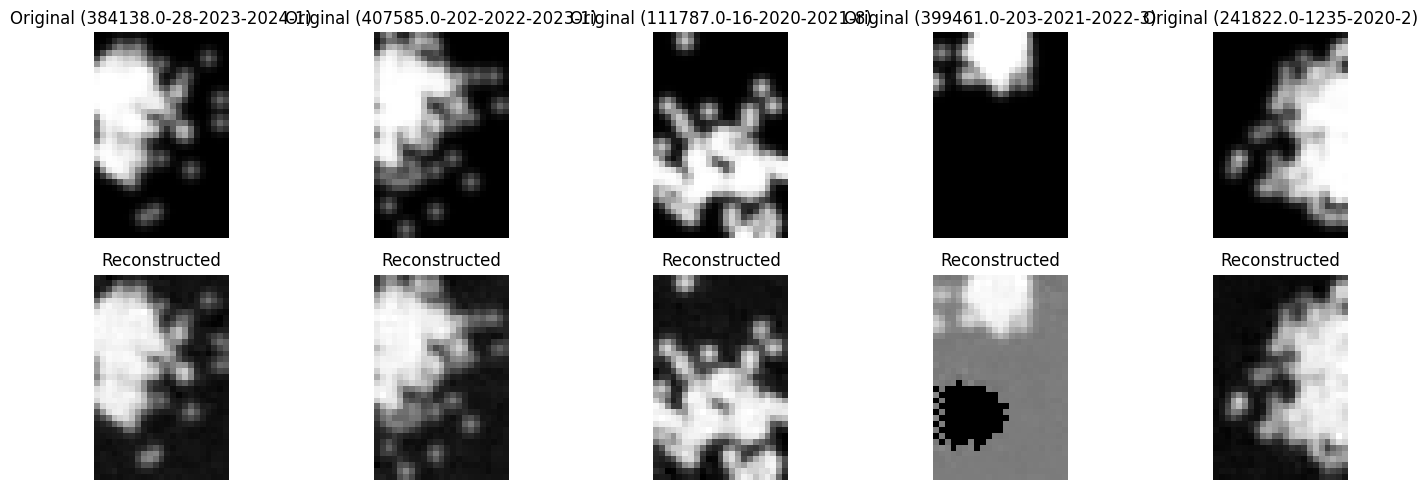

In [57]:
import matplotlib.pyplot as plt

test_set = HeatmapCSVLoader(csv_path="/kaggle/input/sigmoid-10-chunks/passes-start-test.csv")
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Get a batch of images
autoencoder.eval()
images, ids, playerIds, teamIds, seasons = next(iter(test_loader))
images = images.to(device)  # Move images to the selected device

# Reconstruct images
with torch.no_grad():
    reconstructed = autoencoder(images)

# Plot original and reconstructed images (limit to 5 for better visualization)
num_examples = min(len(images), 5)  # Display up to 5 examples
fig, axes = plt.subplots(2, num_examples, figsize=(15, 5))
for i in range(num_examples):
    # Original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    if isinstance(ids, (list, tuple)):
        axes[0, i].set_title(f"Original ({ids[i]})")
    else:
        axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Reconstructed
    axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()